In [11]:
%load_ext autoreload
%autoreload 2

from Experiments import make_experiment
from plot_experiments import *
import yaml

device = 'cmod'
#dataset_path = 'no_ufo_flattop_1452_shots_50%_disruptive'
#dataset_path = 'random_flattop_256_shots_60%_disruptive'
dataset_path = 'no_ufo_flattop_7736_shots_6%_disruptive'
stack_dataset_path = 'no_ufo_flattop_7736_shots_6%_disruptive/stack_4'

# Load models and create experiments

# models, alarms, metrics, and minimum warning times to use
models = ['dsm']
alarms = ['sthr']
metrics = ['auroc']
min_warning_times = [0.02]

# Create a list of experiments
experiment_list = []
for model in models:
    for alarm in alarms:
        for metric in metrics:
            for min_warning_time in min_warning_times:
                config_name = f'{model}_{alarm}_{metric}_{int(min_warning_time*1000)}ms'
                config_path = f'models/{device}/{dataset_path}/{config_name}.yaml'
                # Load yaml file into dictionary
                with open(config_path) as file:
                    config = yaml.load(file, Loader=yaml.FullLoader)

                # For each item in the config, replace it with the value
                for key in config:
                    if type(config[key]) == dict:
                        config[key] = config[key]['value']
                
                # Create test experiment from config
                experiment = make_experiment(config, 'test')
                experiment_list.append(experiment)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded model from models/cmod/no_ufo_flattop_7736_shots_6%_disruptive/dsm_sthr_auroc_20ms.pkl


## Micro Average ROC AUC vs Horizon

See how the models perform at the individual timeslice level across the entire database.

Two trends can be seen:
1. The survival models perform considerably better at longer horizons.
2. The survival models do not benefit as much as the binary classifiers from having temporal data of previous timeslices included in the feature list.

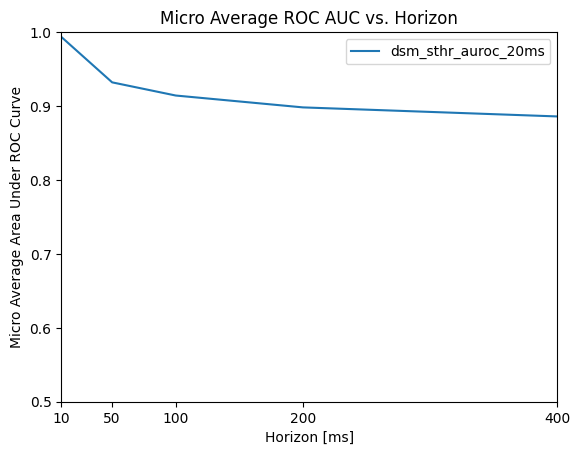

In [3]:
plot_roc_auc_vs_horizon_micro(experiment_list)

# Simple Threshold, 20ms and 100ms alarm performance.

## True Alarm Rate vs False Alarm Rate curve + enclosed area

## Warning Time vs False Alarm Rate curve

## At Best F1:
Avg + Std Warning Time:
True Alarm Rate:
False Alarm Rate:

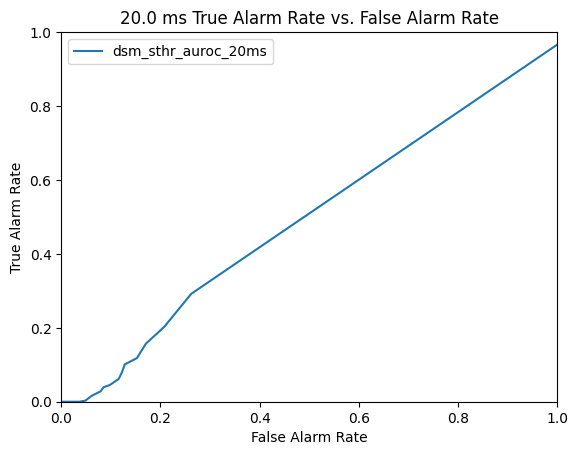

dsm_sthr_auroc_20ms 	 AUROC: 0.49


c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\plot_experiments.py:308: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlabel('False Alarm Rate')


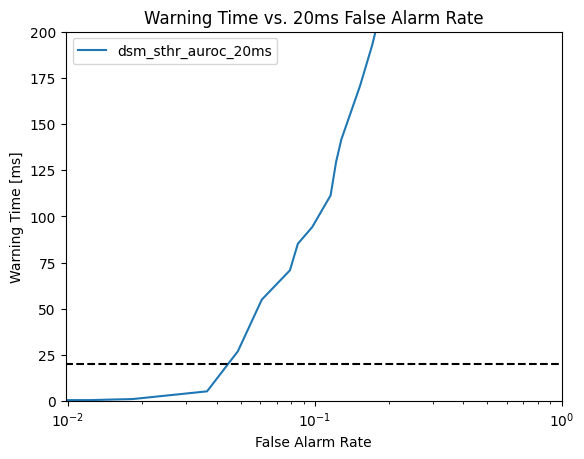

TypeError: Experiment.au_warning_time_false_alarm_rate_curve() got an unexpected keyword argument 'max_far'

In [27]:
required_warning_time = 0.02
plot_TAR_vs_FAR(experiment_list, required_warning_time=required_warning_time)

for experiment in experiment_list:
    auroc = experiment.au_true_alarm_rate_false_alarm_rate_curve(required_warning_time=required_warning_time)
    print(f"{experiment.name} \t AUROC: {auroc:.2f}")

plot_warning_time_vs_FAR(experiment_list, required_warning_time=required_warning_time)

for experiment in experiment_list:
    auwtc = experiment.au_warning_time_false_alarm_rate_curve(required_warning_time=required_warning_time)
    print(f"{experiment.name} \t AUWTC: {auwtc*1000:.2f}")

# Hysteresis, 20ms and 100ms alarm performance

## True Alarm Rate vs False Alarm Rate

## Warning Time vs False Alarm Rate

## At Best F1:
Avg + Std Warning Time:
True Alarm Rate:
False Alarm Rate:

# Expected Time To Disruption (ETTD), 20ms and 100ms alarm performance

## True Alarm Rate vs False Alarm Rate

## Warning TIme vs False Alarm Rate

# One Model Type (several individual models), all above outputs plotted over Ip

In [2]:
plot_disruptive_vs_non_disruptive_shot_durations(experiment_list[0])

NameError: name 'experiment_list' is not defined